In [1]:
%matplotlib inline

Cell-segmentation for H&E stains
================================

This example shows how to use processing and segmentation functions to
segment images with H&E stains.

For a general example of how to use {func}`squidpy.im.segment`, see
{doc}`compute_segment_fluo`.

Note that we only provide a basic built-in segmentation model. If you
require precise cell-segmentation and cell-counts, you might want to add
more pre-processing and/or use a pre-trained model to do the
segmentation (using {func}`squidpy.im.SegmentationCustom`).

:::{seealso}
-   {doc}`compute_segment_fluo` for an
    example on how to calculate a cell-segmentation of a fluorescence
    image.
-   [Nuclei Segmentation using
    Cellpose](../../tutorials/tutorial_cellpose_segmentation.ipynb) for
    a tutorial on using Cellpose as a custom segmentation function.
-   [Nuclei Segmentation using
    StarDist](../../tutorials/tutorial_stardist.ipynb) for a tutorial on
    using StarDist as a custom segmentation function.

:::


In [3]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import squidpy as sq

# load the H&E stained tissue image and crop to a smaller segment
img = sq.datasets.visium_hne_image_crop()
crop = img.crop_corner(0, 0, size=1000)

Before segmenting the image, we smooth it using `squidpy.im.process`.


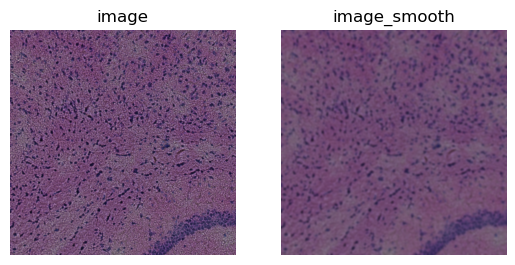

In [4]:
# smooth image
sq.im.process(crop, layer="image", method="smooth", sigma=4)

# plot the result
fig, axes = plt.subplots(1, 2)
for layer, ax in zip(["image", "image_smooth"], axes):
    crop.show(layer, ax=ax)
    ax.set_title(layer)

We will use channel 0 to do the segmentation, as this channel contains
most of the nuclei information within an H&E stain. Instead of using
automatic threshold with [Otsu\'s
method](https://en.wikipedia.org/wiki/Otsu%27s_method), we will define a
manual fixed threshold. Note that using Otsu\'s method to determine the
threshold also yields good results.

Judging by peak in the histogram and the thresholded example image, a
threshold of 90, seems to be a good choice for this example.


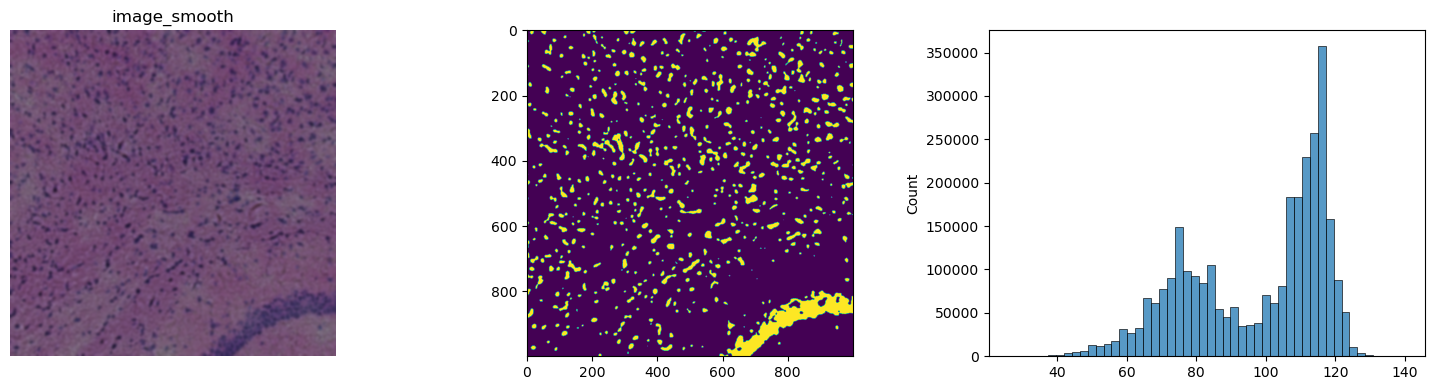

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
crop.show("image_smooth", cmap="gray", ax=axes[0])
axes[1].imshow(crop["image_smooth"][:, :, 0, 0] < 90)
_ = sns.histplot(np.array(crop["image_smooth"]).flatten(), bins=50, ax=axes[2])
plt.tight_layout()

We use `squidpy.im.segment` with `method = 'watershed'` to do the
segmentation. Since, opposite to the fluorescence DAPI stain, in the H&E
stain nuclei appear darker, we need to indicate to the model that it
should treat lower-intensity values as foreground. We do this by
specifying the `geq = False` in the `kwargs`.


In [6]:
sq.im.segment(img=crop, layer="image_smooth", method="watershed", thresh=90, geq=False)

The segmented crop is saved in the layer
[segmented\_watershed]{.title-ref}. This behavior can be changed with
the arguments `copy` and `layer_added`. The result of the segmentation
is a label image that can be used to extract features like the number of
cells from the image.


ImageContainer[shape=(1000, 1000), layers=['image', 'image_smooth', 'segmented_watershed']]
Number of segments in crop: 1182


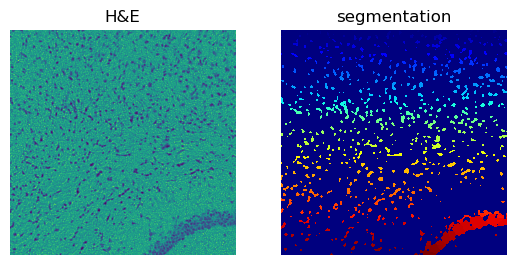

In [7]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_watershed']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_watershed", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")